# EEG Inverse Problem - Julia Native Implementation

Этот ноутбук демонстрирует стабильный подход к решению обратной задачи ЭЭГ:
- **Данные**: Генерируются через Python модуль `eeg_data_generator` (используя PythonCall)
- **Обучение**: Выполняется нативным Julia кодом (InverseNpde модуль)

## Преимущества подхода:
1. **Стабильность**: Julia kernel не падает (нет JuliaCall/PyJulia)
2. **Производительность**: Нативный Julia код для тяжёлых вычислений
3. **Совместимость**: Переиспользование Python кода для генерации данных

## 1. Настройка окружения

In [1]:
# ============================================================
# ВАЖНО: Настраиваем Python из виртуального окружения .venv
# Это должно быть выполнено до любого using PythonCall!
# ============================================================
venv_python = joinpath(@__DIR__, "..", ".venv", "bin", "python")
if isfile(venv_python)
    ENV["JULIA_PYTHONCALL_EXE"] = venv_python
    println("✓ Python из .venv: ", venv_python)
else
    error("Виртуальное окружение .venv не найдено! Запустите: python -m venv .venv && . .venv/bin/activate && pip install -e .")
end

✓ Python из .venv: /home/sasha/inverse-npde/examples/../.venv/bin/python


## 2. Загрузка Julia модулей

In [2]:
# Загружаем главный модуль InverseNpde
# Примечание: При первом запуске может потребоваться время на компиляцию
using Revise
using InverseNpde

println("✓ InverseNpde загружен")
println("Доступные устройства: ", get_available_devices())

📦 InverseProblem модуль загружен
🖥️  Доступные устройства: Dict{String, Any}("cuda_device_count" => 1, "cpu" => true, "cuda_device_name" => ["NVIDIA GeForce RTX 3080"], "cuda" => true)
✓ InverseNpde загружен
Доступные устройства: Dict{String, Any}("cuda_device_count" => 1, "cpu" => true, "cuda_device_name" => ["NVIDIA GeForce RTX 3080"], "cuda" => true)


## 3. Настройка PythonCall и генерация данных

In [3]:
# Загружаем PythonCall для доступа к Python модулям
# Примечание: ENV["JULIA_PYTHONCALL_EXE"] уже установлена в первой ячейке
using PythonCall

# Проверяем, что используется правильный Python
py_python = pyimport("sys")
println("Python executable: ", py_python.executable)

# Добавляем путь к Python пакету inverse_npde
py_python.path.insert(0, joinpath(@__DIR__, "..", "src"))

# Импортируем Python модуль генерации данных
eeg_gen = pyimport("inverse_npde.eeg_data_generator")

println("✓ Python модуль загружен через PythonCall")

Python executable: /home/sasha/inverse-npde/.venv/bin/python
✓ Python модуль загружен через PythonCall


In [4]:
# Создаём генератор данных EEG
# Параметры можно менять для разных экспериментов
num_sensors = 32        # Количество датчиков
sampling_rate = 50.0    # Частота дискретизации (Гц)
duration = 1.0          # Длительность (секунды)
noise_level = 0.005     # Уровень шума
head_type = "adult"     # Тип головы

# Создаём Python объект генератора
py_generator = eeg_gen.EEGDataGenerator(
    num_sensors, sampling_rate, duration, noise_level, head_type
)

# Добавляем источники сигнала по умолчанию
py_generator.create_default_sources()

println("✓ Генератор создан: $num_sensors датчиков, $(sampling_rate)Гц × $(duration)сек")

✓ Генератор создан: 32 датчиков, 50.0Гц × 1.0сек


### 3.1 Визуализация датчиков (из Python)

In [5]:
# Получаем позиции датчиков из Python
# Используем pyconvert для конвертации Python объектов в Julia
py_sensor_positions = py_generator.sensor_gen.get_sensor_positions()
sensor_positions = Matrix{Float64}(undef, num_sensors, 3)
for i in 1:num_sensors
    sensor_positions[i, 1] = pyconvert(Float64, py_sensor_positions[i-1][0])  # x
    sensor_positions[i, 2] = pyconvert(Float64, py_sensor_positions[i-1][1])  # y
    sensor_positions[i, 3] = pyconvert(Float64, py_sensor_positions[i-1][2])  # z
end

# Получаем размеры головы
py_head_dims = py_generator.sensor_gen.get_head_dimensions()
rx = pyconvert(Float64, py_head_dims["rx"])
ry = pyconvert(Float64, py_head_dims["ry"])
rz = pyconvert(Float64, py_head_dims["rz"])

println("✓ Позиции датчиков получены: $num_sensors точек")
println("  Размеры головы: X=$rx, Y=$ry, Z=$rz")

✓ Позиции датчиков получены: 32 точек
  Размеры головы: X=8.5, Y=9.5, Z=10.5


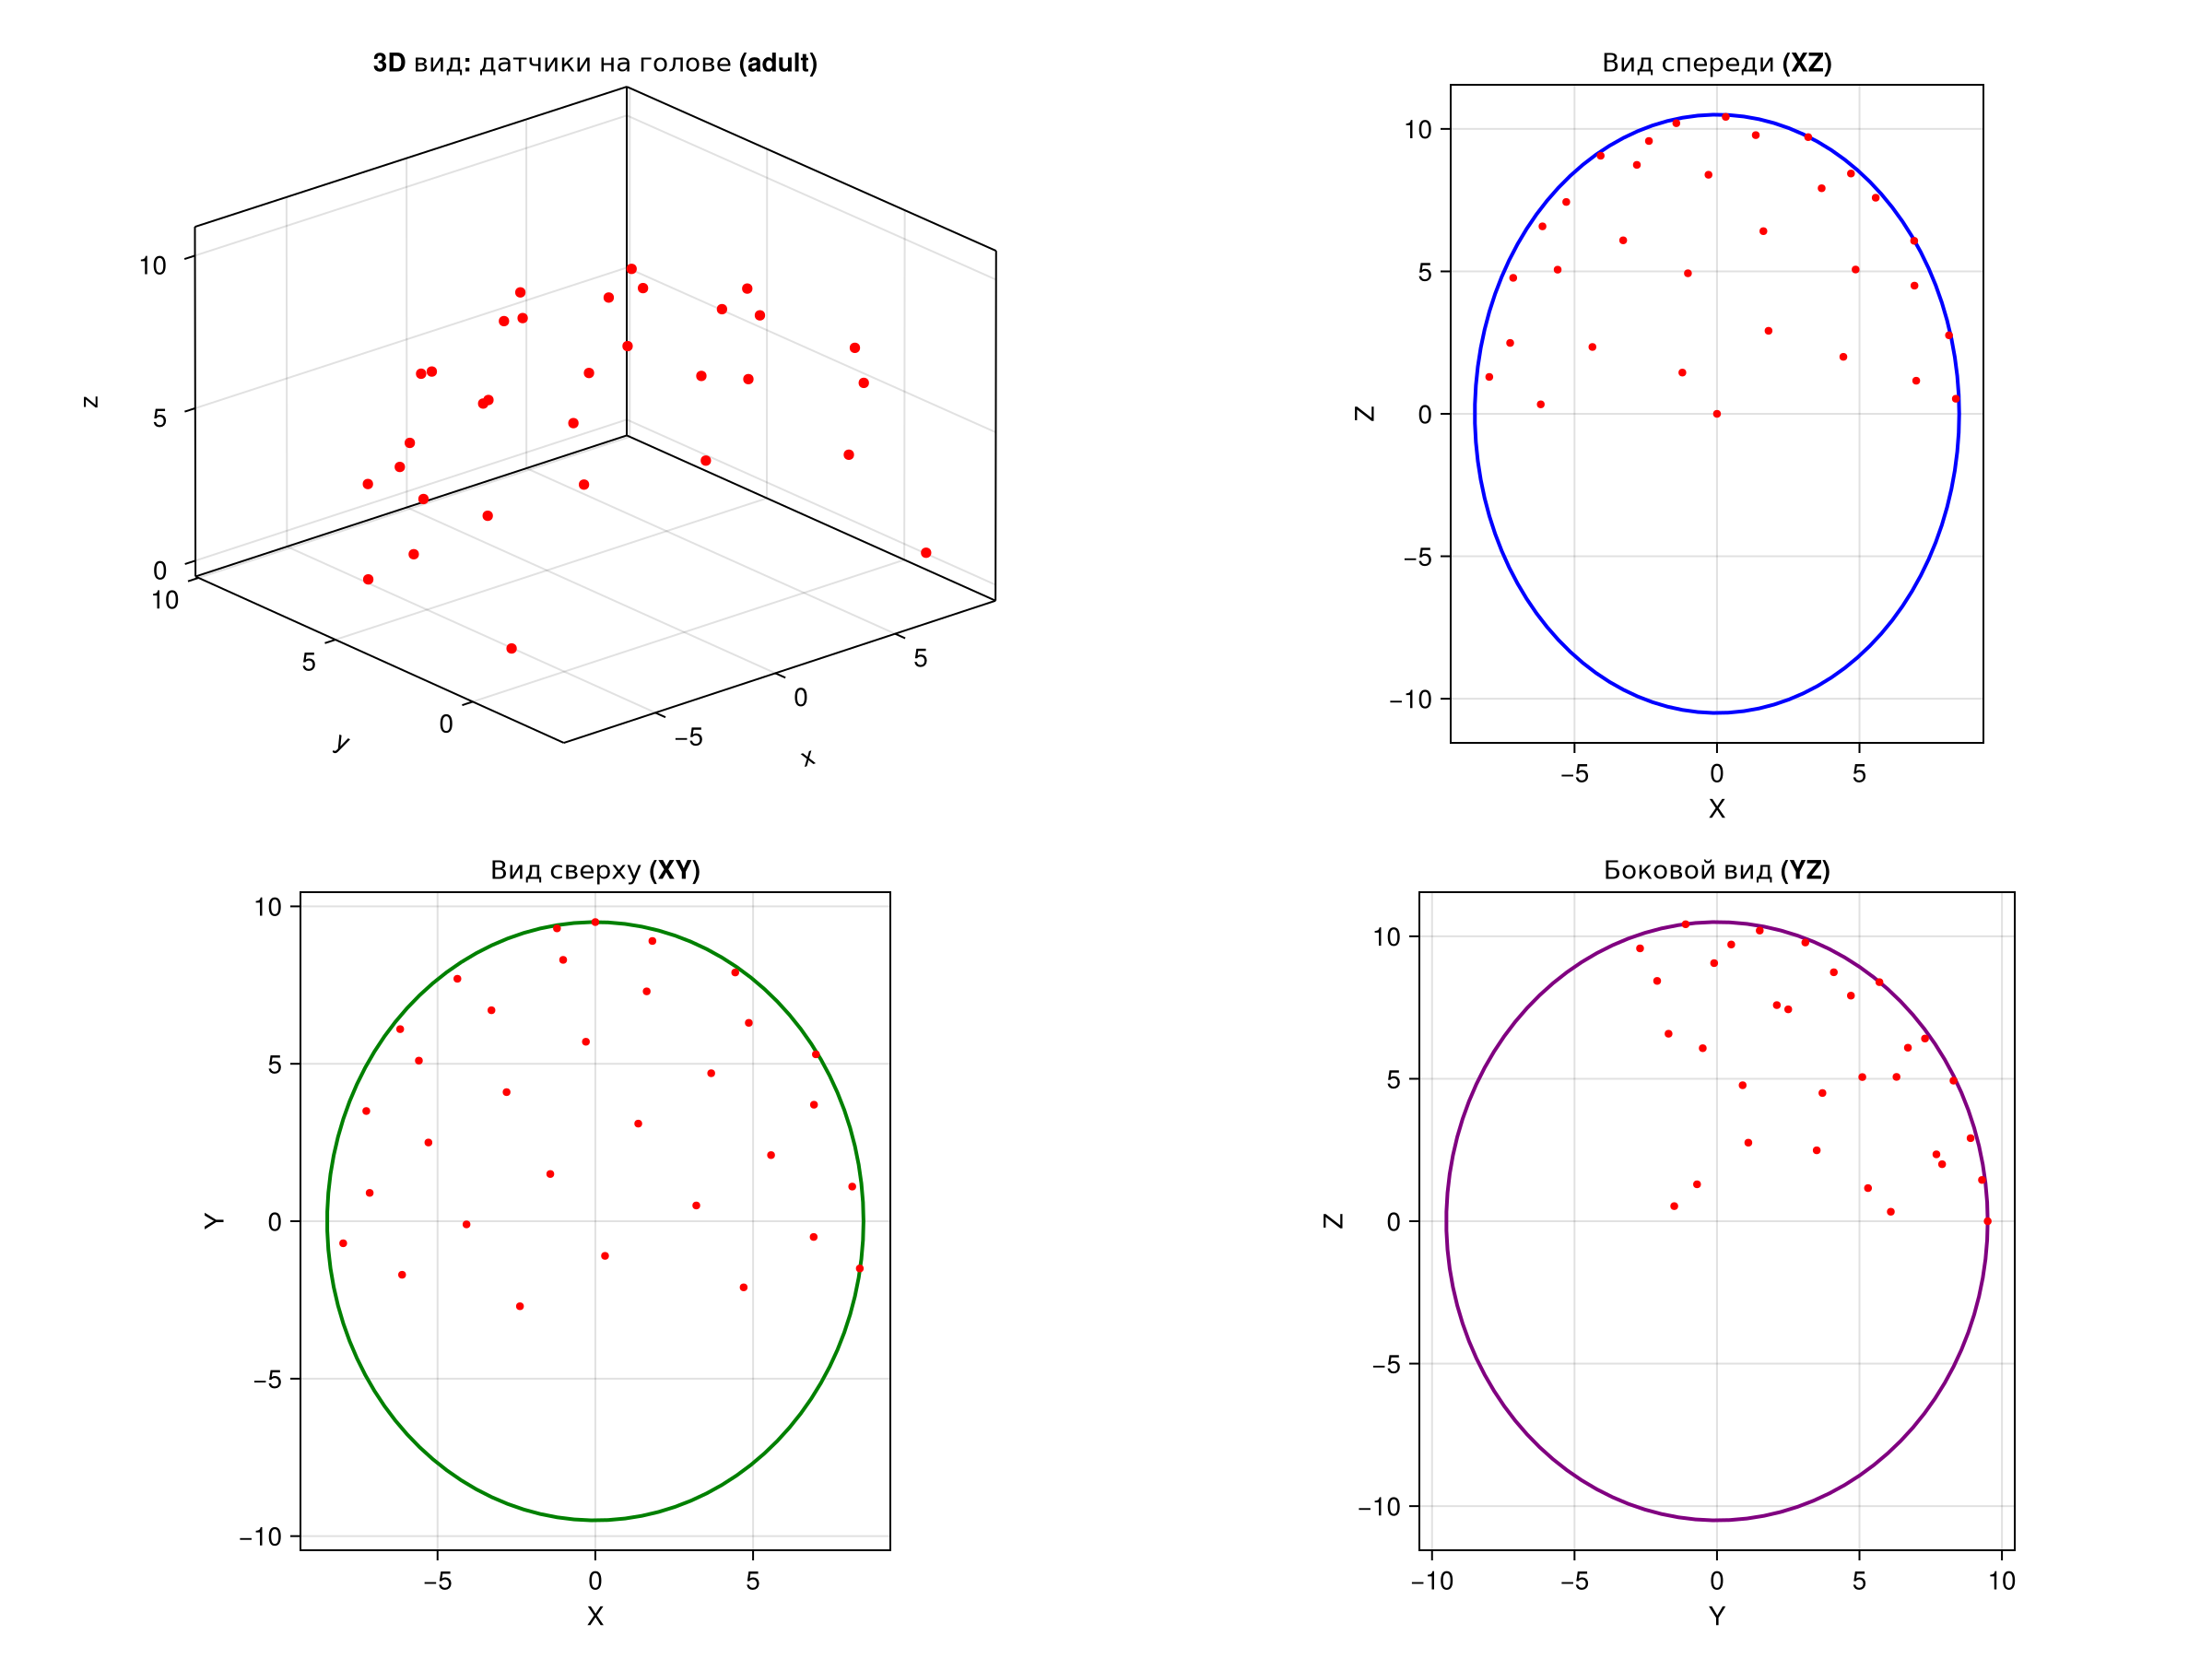

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Визуализация датчиков отображена


In [6]:
using CairoMakie

# Визуализация расположения датчиков (аналогично Python)
# создаём угол сетки
theta = LinRange(0, 2π, 100)

fig = Figure(resolution=(1200, 900))

# 3D вид
ax1 = Axis3(fig[1, 1], title="3D вид: датчики на голове ($head_type)")
scatter!(ax1, sensor_positions[:, 1], sensor_positions[:, 2], sensor_positions[:, 3];
         markersize=8, color=:red)

# Вид спереди (XZ)
ax2 = Axis(fig[1, 2], title="Вид спереди (XZ)", xlabel="X", ylabel="Z", aspect=DataAspect())
x_contour = rx .* cos.(theta)
z_contour = rz .* sin.(theta)
lines!(ax2, x_contour, z_contour; color=:blue, linewidth=2)
scatter!(ax2, sensor_positions[:, 1], sensor_positions[:, 3];
         markersize=6, color=:red)

# Вид сверху (XY)
ax3 = Axis(fig[2, 1], title="Вид сверху (XY)", xlabel="X", ylabel="Y", aspect=DataAspect())
x_top = rx .* cos.(theta)
y_top = ry .* sin.(theta)
lines!(ax3, x_top, y_top; color=:green, linewidth=2)
scatter!(ax3, sensor_positions[:, 1], sensor_positions[:, 2];
         markersize=6, color=:red)

# Боковой вид (YZ)
ax4 = Axis(fig[2, 2], title="Боковой вид (YZ)", xlabel="Y", ylabel="Z", aspect=DataAspect())
y_side = ry .* cos.(theta)
z_side = rz .* sin.(theta)
lines!(ax4, y_side, z_side; color=:purple, linewidth=2)
scatter!(ax4, sensor_positions[:, 2], sensor_positions[:, 3];
         markersize=6, color=:red)

# Отобразить фигуру
display(fig)
println("✓ Визуализация датчиков отображена")


In [7]:
# Генерируем измеренные точки
py_measured_points = py_generator.generate_measured_points()

println("✓ Сгенерировано точек: ", length(py_measured_points))

✓ Сгенерировано точек: 1600


In [8]:
# Извлекаем measured_phi из py_measured_points для визуализации
# Структура py_measured_points: [x, y, z, t, measurement] для каждой точки
# Данные организованы: для каждого t идут все датчики подряд

num_time_steps = Integer(sampling_rate * duration) + 1
measured_phi = zeros(num_sensors, num_time_steps)

# Заполняем матрицу measured_phi[sensor, time_step]
for (idx, point) in enumerate(py_measured_points)
    sensor_idx = (idx % num_sensors) + 1  # Julia индексация с 1
    time_idx = div(idx, num_sensors) + 1
    measured_phi[sensor_idx, time_idx] = pyconvert(Float64, point[4])  # measurement = point[4] (0-indexed в Python)
end

println("Матрица measured_phi извлечена: ", size(measured_phi))

Матрица measured_phi извлечена: (32, 51)


### 3.2 Визуализация временных рядов (измеренные данные)

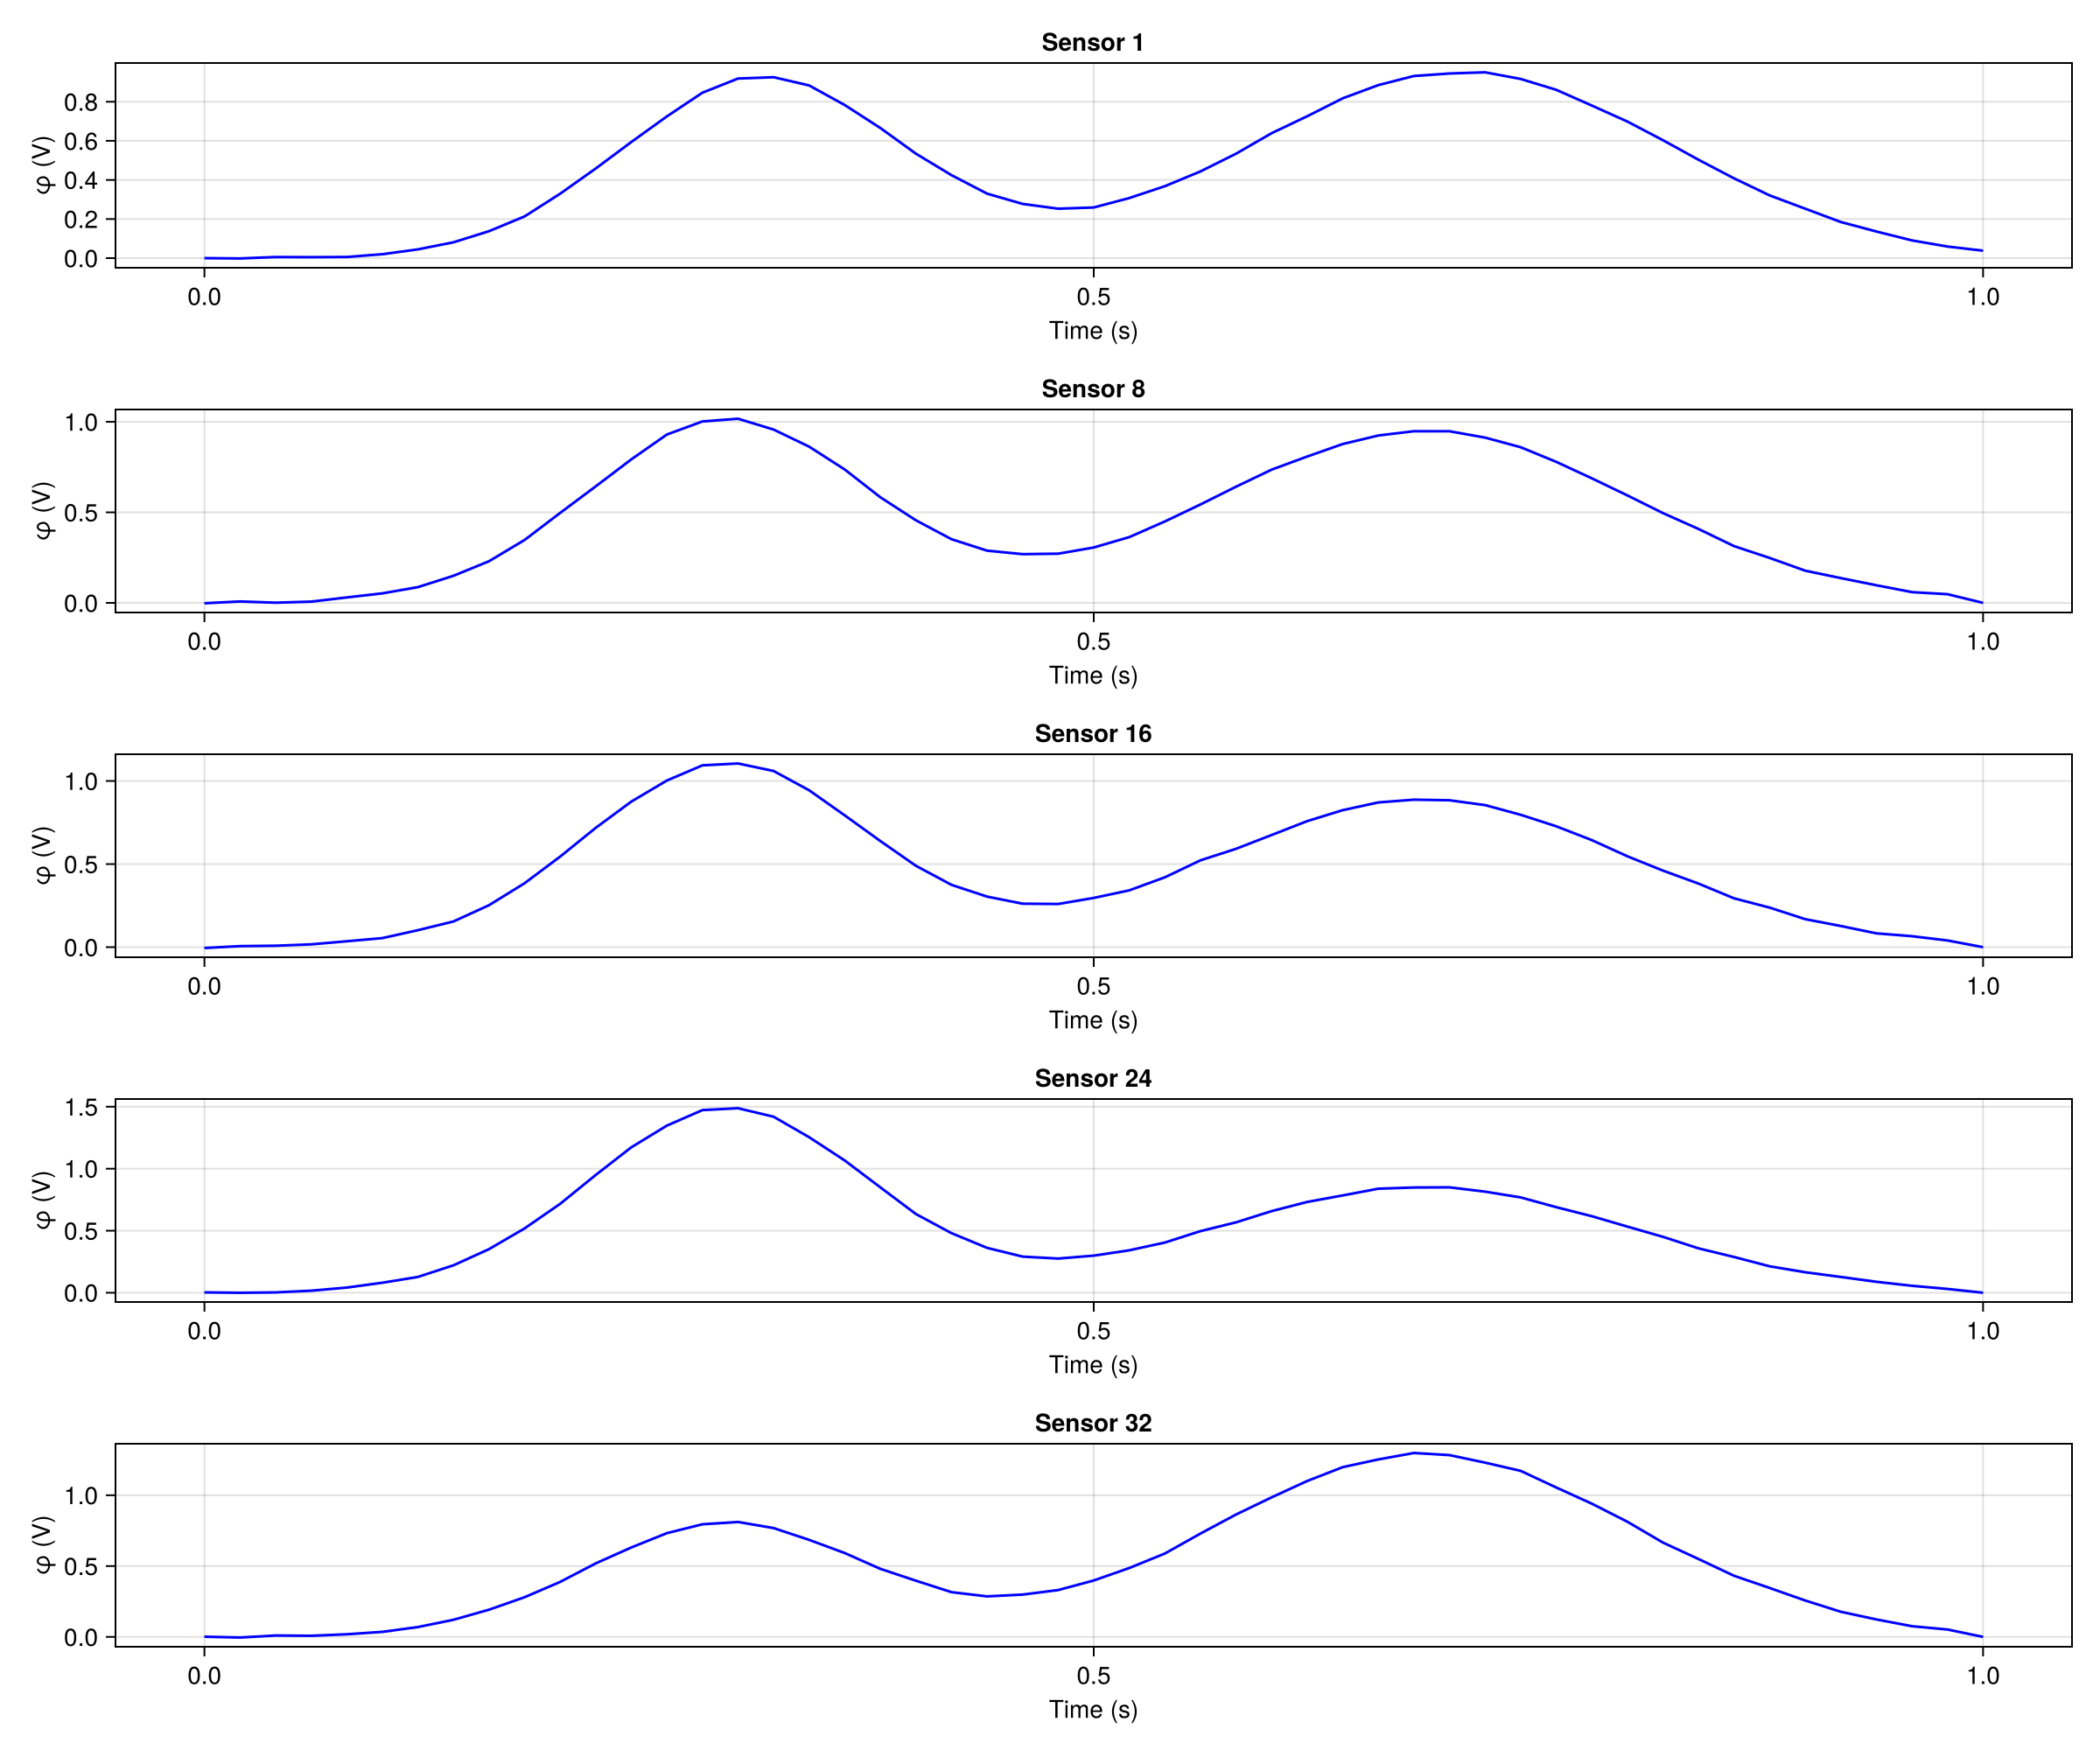

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Временные ряды отображены для датчиков: [1, 8, 16, 24, 32]


In [9]:
using CairoMakie

# Визуализация временных рядов для отдельных датчиков (robust)
num_time_steps = size(measured_phi, 2)
selected_sensors = [1, max(1,div(num_sensors,4)), max(1,div(num_sensors,2)), max(1,3*div(num_sensors,4)), num_sensors]
time_vec = range(0, duration, length=num_time_steps)

fig_ts = Figure(resolution=(1200, 1000), title="Временные ряды измеренных данных")
for (i, sensor_idx) in enumerate(selected_sensors)
    ax = Axis(fig_ts[i, 1]; xlabel="Time (s)", ylabel="φ (V)", title="Sensor $sensor_idx")
    lines!(ax, time_vec, measured_phi[sensor_idx, :]; color=:blue)
end

display(fig_ts)
println("✓ Временные ряды отображены для датчиков: ", selected_sensors)


### 3.3 Пространственное распределение потенциала

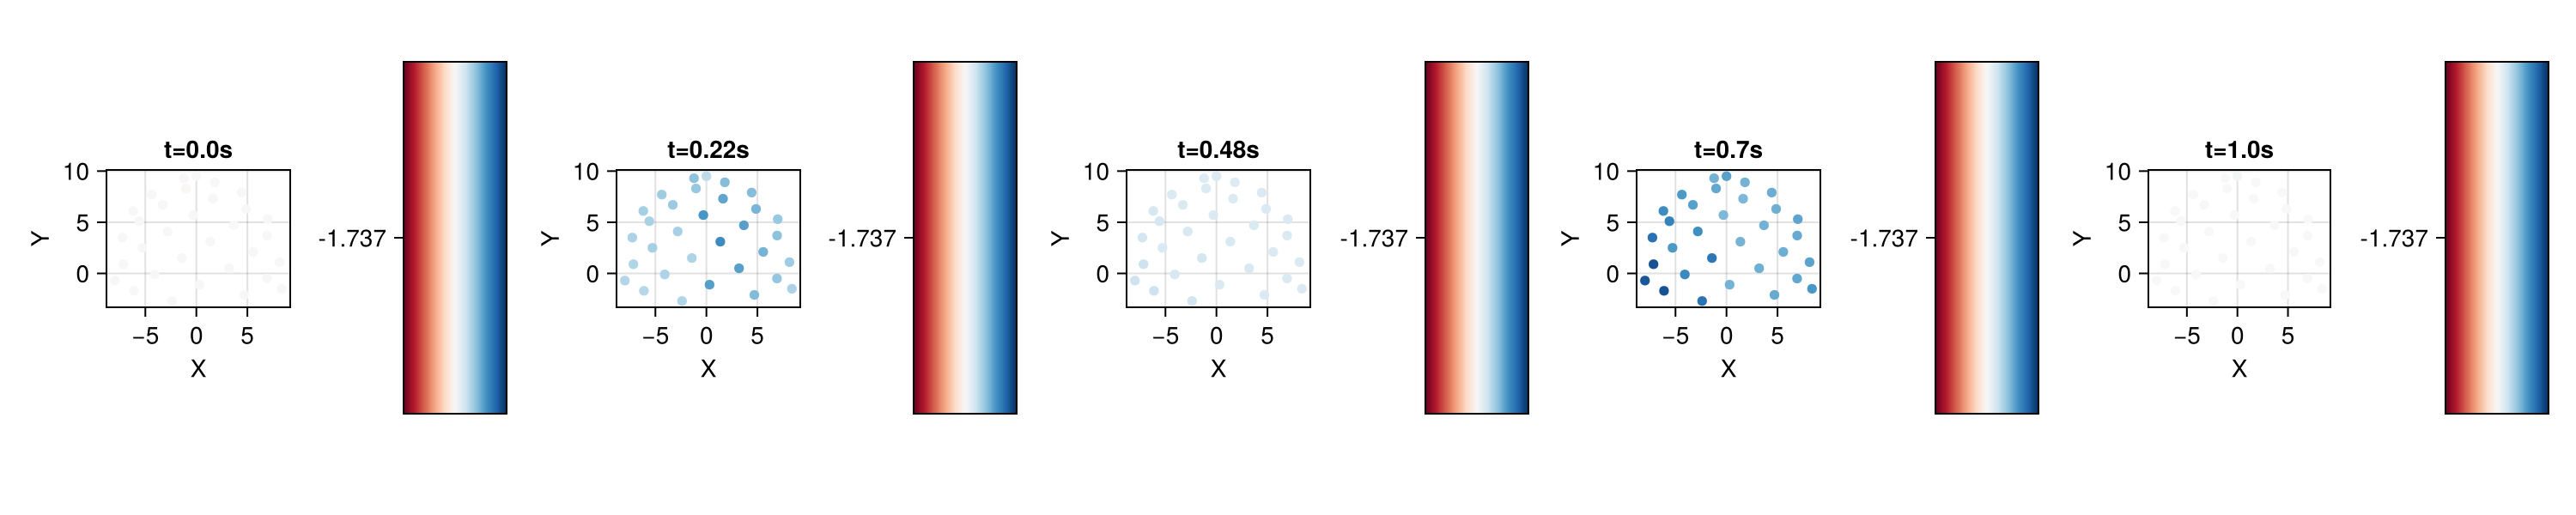

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Пространственное распределение отображено для временных срезов: [1, 12, 25, 36, 51]


In [10]:
using CairoMakie

# Визуализация пространственного распределения потенциала (robust)
num_time_steps = size(measured_phi, 2)
time_vec = range(0, duration, length=num_time_steps)
time_indices = [1, max(1,div(num_time_steps,4)), max(1,div(num_time_steps,2)), max(1,3*div(num_time_steps,4)), num_time_steps]
time_indices = unique(clamp.(time_indices, 1, num_time_steps))

vmax = maximum(abs.(measured_phi))

n = length(time_indices)
fig_spatial = Figure(resolution=(1500, 300))
for (i, t_idx) in enumerate(time_indices)
    t_idx = Int(clamp(t_idx, 1, num_time_steps))
    ax = Axis(fig_spatial[1, 2*i - 1]; title="t=$(round(time_vec[t_idx], digits=3))s", xlabel="X", ylabel="Y", aspect=DataAspect())
    sc = scatter!(ax, sensor_positions[:, 1], sensor_positions[:, 2];
        color=measured_phi[:, t_idx], colormap=:RdBu, markersize=8, colorrange=(-vmax, vmax))

    # Manual colorbar: draw a vertical heatmap in the adjacent column and label ticks
    cbax = Axis(fig_spatial[1, 2*i]; ylabel = "", width = 60)
    cvals = reshape(collect(range(-vmax, vmax, length=256)), 256, 1)
    heatmap!(cbax, cvals; colormap = :RdBu, colorrange = (-vmax, vmax))
    # Map y ticks to color values
    tick_idxs = [1, 64, 128, 192, 256]
    tick_vals = round.(collect(range(-vmax, vmax, length=length(tick_idxs))), digits=3)
    cbax.yticks = (tick_idxs, string.(tick_vals))
    cbax.xticks = ([], [])
end

display(fig_spatial)
println("✓ Пространственное распределение отображено для временных срезов: ", time_indices)


## 4. Конвертация данных из Python в Julia

In [11]:
"""
    convert_py_points_to_julia(py_points) -> Vector{Vector{Float64}}

Конвертирует Python список измеренных точек в Julia формат.

Формат точки: [x, y, z, t, phi_measured]
"""
function convert_py_points_to_julia(py_points)
    n_points = length(py_points)
    julia_points = Vector{Vector{Float64}}(undef, n_points)
    
    for i in 1:n_points
        py_point = py_points[i-1]  # Python индексация с 0
        julia_points[i] = [
            pyconvert(Float64, py_point[0]),  # x
            pyconvert(Float64, py_point[1]),  # y
            pyconvert(Float64, py_point[2]),  # z
            pyconvert(Float64, py_point[3]),  # t
            pyconvert(Float64, py_point[4])   # phi_measured
        ]
    end
    
    return julia_points
end

# Конвертируем данные
measured_points = convert_py_points_to_julia(py_measured_points)

println("✓ Конвертировано в Julia: $(length(measured_points)) точек")
println("Пример первой точки: ", measured_points[1])

✓ Конвертировано в Julia: 1600 точек
Пример первой точки: [0.0, 9.5, 0.0, 0.0, 0.004753185490968139]


## 5. Настройка конфигураций для обучения

In [12]:
# === ОПЦИЯ 1: Стандартная MLP архитектура (ЗАКОММЕНТИРОВАНА - используйте Temporal-Aware ниже) ===
# nn_config_standard = NeuralNetworkConfig(;
#     input_dim = 4,                    # [x, y, z, t]
#     hidden_layers = [32, 32],         # Архитектура скрытых слоёв
#     output_dim = 8,                   # [φ, Ax, Ay, Az, ρ, jx, jy, jz]
#     activation =:tanh,                # Функция активации
#     use_gpu = true                    # Использовать GPU если доступен
# )
#
# println("✓ Стандартная MLP архитектура:")
# println("  Input: [x,y,z,t] (4D)")
# println("  Hidden: $(nn_config_standard.hidden_layers)")
# println("  Output: $(nn_config_standard.output_dim)D")


In [13]:
# === ОПЦИЯ 2: Temporal-Aware архитектура (АКТИВНА - РЕКОМЕНДУЕТСЯ) ===
# Эта архитектура явно разделяет пространственные и временные признаки через Fourier features
# Решает проблему стационарности исходной MLP архитектуры

nn_config = TemporalAwareNetworkConfig(;
    # Spatial branch параметры
    spatial_hidden_layers = [32, 32],      # Dense слои для пространства [x,y,z]
    spatial_output_dim = 32,               # Выход spatial branch
    
    # Temporal branch параметры
    num_fourier_frequencies = 32,           # Fourier частоты k=1..8 (16 features: sin+cos)
    temporal_hidden_layers = [16],         # Dense слои для Fourier(t)
    temporal_output_dim = 16,              # Выход temporal branch
    
    # Fusion параметры
    fusion_hidden_layers = [32, 32],           # Dense слои после объединения
    
    output_dim = 8,                        # Финальный выход: [φ, Ax, Ay, Az, ρ, jx, jy, jz]
    activation = :tanh,                    # Функция активации
    use_gpu = true
)

println("✓ Temporal-Aware архитектура (активна для тренировки):")
println("  Spatial branch:  [x,y,z] → $(nn_config.spatial_hidden_layers) → $(nn_config.spatial_output_dim)D")
println("  Fourier features: $(nn_config.num_fourier_frequencies) freq. → $(2*nn_config.num_fourier_frequencies)D features (sin+cos pairs)")
println("  Temporal branch: $(2*nn_config.num_fourier_frequencies)D → $(nn_config.temporal_hidden_layers) → $(nn_config.temporal_output_dim)D")
println("  Fusion layer:    $(nn_config.spatial_output_dim + nn_config.temporal_output_dim)D → $(nn_config.fusion_hidden_layers) → $(nn_config.output_dim)D")
println()
println("  Архитектура:")
println("    [x,y,z] ─────────────┐")
println("    [t] → Fourier(8) ──→ Fusion → [φ, Ax, Ay, Az, ρ, jx, jy, jz]")
println()
println("  ✅ Эта архитектура гарантирует явную зависимость от времени через Fourier features")

✓ Temporal-Aware архитектура (активна для тренировки):
  Spatial branch:  [x,y,z] → [32, 32] → 32D
  Fourier features: 32 freq. → 64D features (sin+cos pairs)
  Temporal branch: 64D → [16] → 16D
  Fusion layer:    48D → [32, 32] → 8D

  Архитектура:
    [x,y,z] ─────────────┐
    [t] → Fourier(8) ──→ Fusion → [φ, Ax, Ay, Az, ρ, jx, jy, jz]

  ✅ Эта архитектура гарантирует явную зависимость от времени через Fourier features


In [14]:
# Конфигурация оптимизации
opt_config = OptimizationConfig(;
    optimizer = :adam,                # Оптимизатор Adam
    learning_rate = 0.001,            # Скорость обучения
    max_iterations = 150,            # Количество итераций
    log_frequency = 5,               # Частота логирования
    use_tensorboard = true,           # Логирование в TensorBoard
    log_directory = "logs/eeg_julia_exp"
)

println("✓ Оптимизация: $(opt_config.optimizer), lr=$(opt_config.learning_rate), iter=$(opt_config.max_iterations)")

✓ Оптимизация: adam, lr=0.001, iter=150


In [15]:
# Конфигурация функции потерь с адаптивным балансом (improvement-based scheduler)
loss_config = LossFunctionConfig(;
    lambda_pde = 0.001,                 # Вес PDE потерь
    lambda_bc = 1.0,                  # Вес граничных условий
    lambda_data_init = 10.0,           # Начальный вес данных
    lambda_time = 1.0,                 # Вес потерь по времени (если используется)
    # using improvement-based scheduler
    lambda_min = 1.0,               # Минимум lambda_data (global)
    lambda_max = nothing,             # Максимум lambda_data (global)
    measured_points = measured_points, # Измеренные точки
    lambda_schedule_type = :improvement,
    lambda_schedule = Dict{String,Any}("window_size" => 10, "increase_factor" => 1.0, "decrease_factor" => 1.0, "patience" => 3, "min_improvement" => 3e-2, "lambda_min" => 1.0, "lambda_max" => 1e14),
    lambda_field = 10.0,
    field_energy_scale = 3.0,
    num_field_time_samples = 5,  # Количество временных срезов для интегрирования
    enable_adaptive_loss=false,  # По умолчанию отключено
    adaptive_loss_reweight_every=5,  # Пересчитывать веса каждые 100 итераций
    adaptive_weight_inertia=0.9 
)

println("✓ Loss scheduler: $(loss_config.lambda_schedule_type), lambda_init=$(loss_config.lambda_data_init), λ∈[$(loss_config.lambda_min), $(loss_config.lambda_max)]")

✓ Loss scheduler: improvement, lambda_init=10.0, λ∈[1.0, nothing]


In [16]:
# Конфигурация PML (Perfectly Matched Layer)
pml_config = PMLConfig(;
    enabled = true,                   # Включить PML
    pml_thickness_ratio = 0.1,        # Толщина PML (10% от домена)
    reflection_coefficient = 0.001,   # Коэффициент отражения
    gamma_max = nothing,              # Автоматический расчёт
    alpha_max = nothing               # Автоматический расчёт
)

println("✓ PML: включён, толщина=$(pml_config.pml_thickness_ratio*100)%")

✓ PML: включён, толщина=10.0%


In [17]:
# Конфигурация домена
# Используем уже сконвертированные размеры rx, ry, rz из предыдущей ячейки

domain_config = Dict{Any, Any}(
    "x_range" => [-13.0, 13.0],
    "y_range" => [-13.0, 13.0],
    "z_range" => [-13.0, 13.0],
    "t_range" => [0.0, 1],  # Соответствует продолжительности 0.5 сек
    "num_points" => 4 * 1024
)

println("✓ Домен: X∈$(domain_config["x_range"]), Y∈$(domain_config["y_range"]), Z∈$(domain_config["z_range"])")

✓ Домен: X∈[-13.0, 13.0], Y∈[-13.0, 13.0], Z∈[-13.0, 13.0]


In [18]:
const_config = PhysicalConstants(; c=1.0, ε=1.0, μ=1.0,ε₀=1.0, μ₀=1.0)

PhysicalConstants(1.0, 1.0, 1.0, 1.0, 1.0)

## 6. Запуск обучения

In [19]:
run(`bash -c "source $(@__DIR__)/../.venv/bin/activate && tensorboard --logdir=logs --port=6006"`, wait=false)

Process(`bash -c 'source /home/sasha/inverse-npde/examples/../.venv/bin/activate && tensorboard --logdir=logs --port=6006'`, ProcessRunning)

## Почему Temporal-Aware решает проблему стационарных решений?

**Проблема**: Стандартная MLP модель часто игнорирует время $t$ и учит стационарные (независящие от времени) решения.

**Решение через Temporal-Aware архитектуру**:

1. **Явное кодирование времени через Fourier features**:
   - Вместо прямого использования $t$ на входе, применяем периодическое расширение:
   - $\Phi_t = [\sin(\pi t), \cos(\pi t), \sin(2\pi t), \cos(2\pi t), \ldots, \sin(n\pi t), \cos(n\pi t)]$
   - Это  представление размерности 2n гарантирует упрощает пространство обучения для нейросети раскладывая процессы на волны

2. **Разделённые пространственно-временные ветви**:
   - **Пространственная ветвь**: Процессирует $[x, y, z]$ → 32D признаки
   - **Временная ветвь**: Процессирует Fourier features → 16D признаки
   - **Слой слияния**: Комбинирует 48D → 8D выходные переменные
   - Это разделение заставляет сеть явно учитывать оба аспекта

3. **Исправление точек вычисления производных**:
   - Производные из натуральных кубических сплайнов вычисляются в средних точках интервалов времени ($t_{mid}$)
   - Мы теперь оцениваем нейронную сеть в этих же точках для согласованности
   - Это устраняет несогласованность между точками вычисления в данных и в сетевых вычислениях

**Ожидаемый результат**: Обученная модель будет показывать явную временную эволюцию, а не статионарное решение.

In [20]:
println("🚀 Запуск решения обратной задачи ЭЭГ с Temporal-Aware архитектурой...")
println("=" ^ 70)
println("Конфигурация:")
println("  Архитектура: Temporal-Aware (Fourier features для явной временной зависимости)")
println("  Оптимизатор: $(opt_config.optimizer)")
println("  Макс итерации: $(opt_config.max_iterations)")
println("  Schedule: $(loss_config.lambda_schedule_type)-based λ_data адаптация")
println("=" ^ 70)

# Запускаем эксперимент с Temporal-Aware конфигурацией
results = run_eeg_inverse_problem(;
    measured_points = measured_points,
    nn_config = nn_config,              # ← Temporal-Aware конфиг
    opt_config = opt_config,
    loss_config = loss_config,
    domain_config = domain_config,
    pml_config = pml_config
)

println("=" ^ 70)
println("✅ Обучение завершено!")

🚀 Запуск решения обратной задачи ЭЭГ с Temporal-Aware архитектурой...
Конфигурация:
  Архитектура: Temporal-Aware (Fourier features для явной временной зависимости)
  Оптимизатор: adam
  Макс итерации: 150
  Schedule: improvement-based λ_data адаптация
🚀 Запуск эксперимента обратной задачи ЭЭГ...
✅ PML включён (толщина: 10.0%, R: 0.001)
   γ_max: auto, α_max: auto
✓ Данные нормированы, фактор: 0.510748
✓ Temporal-Aware архитектура:
   Spatial: [x,y,z] → [32, 32] → 32D
   Temporal: Fourier(32) → [16] → 16D
   Fusion: 48D → [32, 32] → 8D
✓ Используем нормированные измеренные точки
✓ Настройка создана


┌ Info: Using NonAdaptiveLoss with lambda_pde=0.001, lambda_bc=1.0
└ @ InverseNpde.Optimization /home/sasha/inverse-npde/src/neural_pde_solver/Optimization.jl:672
┌ Info: Constructing PhysicsInformedNN (GPU-first). Ensure chain and params are on desired device
└ @ InverseNpde.Optimization /home/sasha/inverse-npde/src/neural_pde_solver/Optimization.jl:676


✓ Discretization создан (адаптивный планировщик: improvement)
✓ PDE система дискретизирована
🔄 Начинаем оптимизацию...


┌ Warning: Mixed Precision Inputs received for `weight`: CUDA.CuArray{Float32, 2, CUDA.DeviceMemory} and `x`: CUDA.CuArray{Float64, 2, CUDA.DeviceMemory}. Promoting to Float64.
└ @ LuxLibCUDAExt /home/sasha/.julia/packages/LuxLib/utJLG/ext/LuxLibCUDAExt/cublaslt.jl:41
0.7%┣▎                                         ┫ 1/150 [04:03<Inf:Inf, InfGs/it]
1.3%┣┫ 2/150 [04:10<10:17:24, 250s/it, Loss: 1.95e7, PDE: 1.92e10, Data: 60.8, Deriv: 692.0, E_fld: 0.515, L_fld: 0.842, λ: 10.0]
2.0%┣┫ 3/150 [04:16<05:13:29, 128s/it, Loss: 1.71e7, PDE: 1.65e10, Data: 61.1, Deriv: 635.0, E_fld: 0.476, L_fld: 0.853, λ: 10.0]
2.7%┣┫ 4/150 [04:21<03:31:43, 87s/it, Loss: 1.54e7, PDE: 1.49e10, Data: 61.6, Deriv: 584.0, E_fld: 0.391, L_fld: 0.878, λ: 10.0]
3.3%┣┫ 5/150 [04:26<02:40:48, 67s/it, Loss: 1.35e7, PDE: 1.39e10, Data: 62.0, Deriv: 537.0, E_fld: 0.44, L_fld: 0.864, λ: 10.0]
4.0%┣┫ 6/150 [04:32<02:10:38, 54s/it, Loss: 1.26e7, PDE: 1.27e10, Data: 62.5, Deriv: 494.0, E_fld: 0.333, L_fld: 0.895, λ: 10.0]
4.7%

✓ Оптимизация завершена


100.7%┣┫ 151/150 [18:19<00:-7, 7s/it, Loss: 235000.0, PDE: 2.33e8, Data: 56.5, Deriv: 82.4, E_fld: -0.305, L_fld: 1.11, λ: 10.0]
┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}] x B [Matrix{Float64}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl /home/sasha/.julia/packages/LuxLib/utJLG/src/impl/matmul.jl:190


📊 Расчет значений φ по равномерной сетке для визуализации...
  ⏰ Обработка временного шага t = 0.0
  ⏰ Обработка временного шага t = 0.245
  ⏰ Обработка временного шага t = 0.49
  ⏰ Обработка временного шага t = 0.735
  ⏰ Обработка временного шага t = 0.98
✓ Расчет равномерной сетки завершен
✅ Обучение завершено!


In [21]:
using  JLD2: jldopen
function save_results0(results, filename::String)
    # Сохраняем основные результаты
    jldopen(filename, "w") do file
        file["solution"] = results.solution
        file["discretization"] = results.discretization
        file["phi"] = results.phi
        file["params"] = results.params
        file["results"] = results.results
        file["setup"] = results.setup
    end
    
    println("✓ Результаты сохранены в $filename")
end

┌ Error: Failed to revise /home/sasha/inverse-npde/src/neural_pde_solver/PDEDefinitions.jl
│   exception = Revise.ReviseEvalException("/home/sasha/inverse-npde/src/neural_pde_solver/PDEDefinitions.jl:40", ErrorException("invalid redefinition of constant PDEDefinitions.VariableSet"), Any[(top-level scope at PDEDefinitions.jl:40, 1)])
└ @ Revise /home/sasha/.julia/packages/Revise/b0dDX/src/packagedef.jl:898
┌ Error: Failed to revise /home/sasha/inverse-npde/src/neural_pde_solver/NeuralNetwork.jl
│   exception = Revise.ReviseEvalException("/home/sasha/inverse-npde/examples/none:0", UndefVarError(:Random, InverseNpde), Any[(top-level scope at none:0, 1)])
└ @ Revise /home/sasha/.julia/packages/Revise/b0dDX/src/packagedef.jl:898
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/sasha/inverse-npde/src/neural_pde_solver/PDEDefinitions.jl
│   /home/sasha/inverse-npde/src/neural_pde_solver/NeuralNetwork.jl
│ 
│ If the error was due to evaluation 

save_results0 (generic function with 1 method)

In [22]:
#Сохраняем результаты в JLD2 файл для последующего анализа
save_results(results, "experiment_results.jld2")

┌ Warning: Attempting to store InverseNpde.NeuralNetwork.var"#21#22".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /home/sasha/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447
┌ Warning: Attempting to store InverseNpde.NeuralNetwork.var"#21#22".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /home/sasha/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447
┌ Warning: Attempting to store InverseNpde.Optimization.var"#additional_loss#13"{LossFunctionConfig, Base.RefValue{Float64}, Bool, Base.RefValue{NamedTuple}, Base.RefValue{NamedTuple}, Int64, Float64, Float64, Vector{Float32}, Float64, Int64, Int64, Matrix{Float32}, Vector{Float32}, Vector{Float32}, Matrix{Float32}, Int64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /home/sasha/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447
┌ Warning: Attempting

✓ Результаты сохранены в experiment_results.jld2


In [23]:
function load_results0(filename::String)
    if !isfile(filename)
        throw(ArgumentError("Файл $filename не найден"))
    end
    results = Dict{String, Any}()
    jldopen(filename, "r") do file
        results["solution"] = file["solution"]
        results["discretization"] = file["discretization"]
        results["phi"] = file["phi"]
        results["params"] = file["params"]
        results["results"] = file["results"]
        results["setup"] = file["setup"]
    end
    
    println("✓ Результаты загружены из $filename")
    return results
end

load_results0 (generic function with 1 method)

In [24]:
# Для загрузки результатов в будущем:
#results = load_results("experiment_results.jld2")

## 7. Анализ результатов

In [25]:
# Извлекаем результаты
analysis = results.results

println("📊 Метрики на датчиках:")
println("   MSE: $(round(analysis["overall_mse"], digits=6))")
println("   MAE: $(round(analysis["overall_mae"], digits=6))")
println("   Max Error: $(round(analysis["overall_max_error"], digits=6))")
println("   Финальный λ_data: $(round(results.final_lambda_data, digits=4))")

📊 Метрики на датчиках:
   MSE: 0.606905
   MAE: 0.651581
   Max Error: 1.901646
   Финальный λ_data: 10.0


### 7.2 Визуализация предсказанных данных

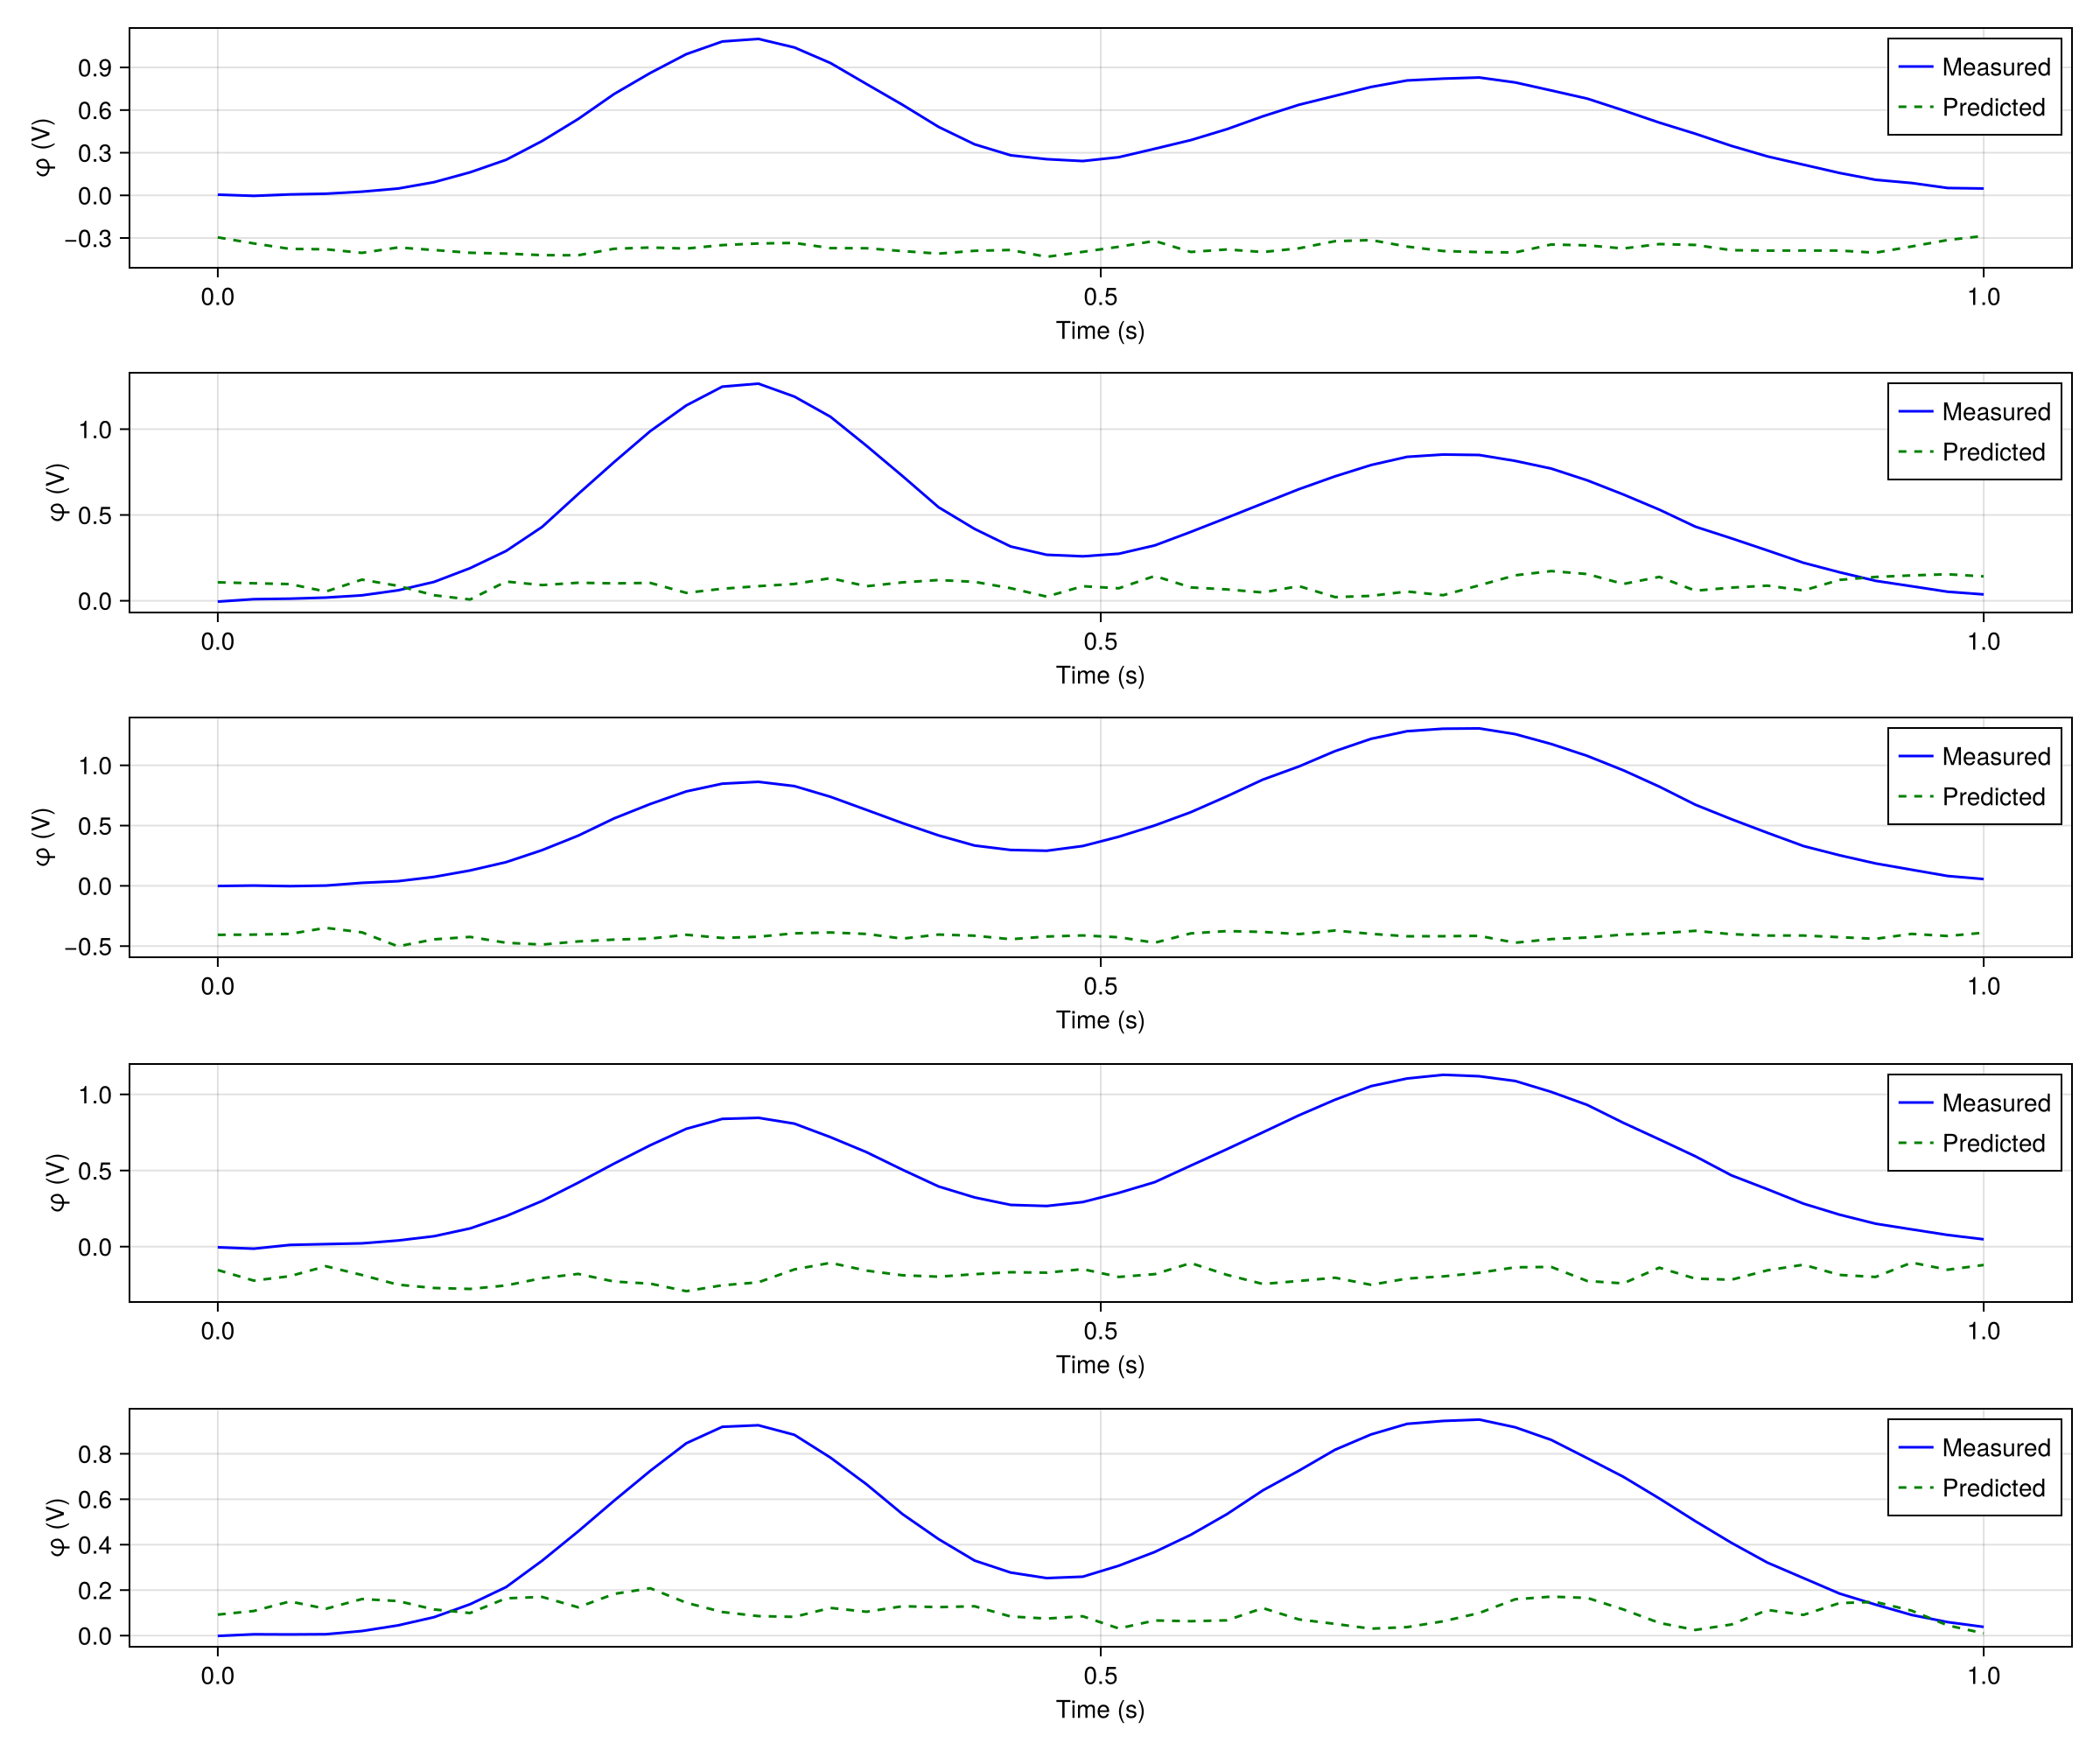

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Предсказанные временные ряды отображены (overlay)


In [26]:
using CairoMakie

# Предсказанные временные ряды и overlay с измеренными (robust)
# извлекаем данные из analysis (должны быть после run)
if !haskey(analysis, "sensor_data")
    error("analysis[\"sensor_data\"] missing")
end
sensor_data = analysis["sensor_data"]
x_coords = sensor_data["x_coords"]; y_coords = sensor_data["y_coords"]; z_coords = sensor_data["z_coords"]; t_coords = sensor_data["t_coords"]
measured_vec = sensor_data["measured_phi"]
predicted_vec = haskey(sensor_data, "predicted_phi") ? sensor_data["predicted_phi"] : nothing

# Reshape и подготовка (robust inference of sizes)
L = length(measured_vec)

function infer_dims(L, sensor_positions, analysis)
    candidates = Int[]
    if @isdefined sensor_positions
        push!(candidates, size(sensor_positions,1))
    end
    if haskey(analysis, "num_sensors")
        push!(candidates, Int(analysis["num_sensors"]))
    end
    if haskey(analysis, "num_time_steps")
        push!(candidates, Int(analysis["num_time_steps"]))
    end

    # add divisors of L (reasonable range)
    for i in 1:floor(Int, sqrt(L))
        if L % i == 0
            push!(candidates, i)
            push!(candidates, L ÷ i)
        end
    end
    candidates = unique(filter(x -> x>0 && x<=L, candidates))

    # prefer sensor_positions match
    if @isdefined sensor_positions
        sp = size(sensor_positions,1)
        if sp in candidates && L % sp == 0
            return sp, Int(L/sp)
        end
    end

    # prefer known num_time_steps
    if haskey(analysis, "num_time_steps")
        nt = Int(analysis["num_time_steps"])
        if nt>0 && L % nt == 0
            return Int(L/nt), nt
        end
    end

    # pick a reasonable candidate (sensors <=512)
    sortc = sort(candidates)
    for ns in sortc
        nt = L ÷ ns
        if ns>1 && nt>1 && ns<=512
            return ns, nt
        end
    end

    # fallback: treat as sensors × 1
    return L, 1
end

num_sensors, num_time_steps = infer_dims(L, sensor_positions, analysis)
if num_sensors * num_time_steps != L
    error("Incompatible measured vector length=$(L) with inferred num_sensors=$(num_sensors) and num_time_steps=$(num_time_steps); please check analysis or sensor_positions")
end

# если предсказания ещё не вычислены, делаем пакетный вызов
if predicted_vec === nothing
    println("predicted_phi not present in analysis — computing batch predictions...")
    all_data = hcat(results.measured_points...)
    coords_batch = Float64.(all_data[1:4, :])
    params = results.params
    pred_all = results.phi(coords_batch, params)
    phi_pred_norm = Float64.(vec(pred_all[1, :]) |> cpud)
    predicted_vec = phi_pred_norm .* (haskey(analysis, "norm_factor") ? analysis["norm_factor"] : 1.0)
    sensor_data["predicted_phi"] = predicted_vec
end

measured_mat = reshape(Float64.(measured_vec), num_sensors, num_time_steps)
predicted_mat = reshape(Float64.(predicted_vec), num_sensors, num_time_steps)

selected_sensors = [1, max(1,div(num_sensors,4)), max(1,div(num_sensors,2)), max(1,3*div(num_sensors,4)), num_sensors]
time_vec = range(0, duration, length=num_time_steps)

fig_pred_ts = Figure(resolution=(1200,1000), title="Временные ряды: измеренное (синее) vs предсказанное (зелёное)")
for (i, sensor_idx) in enumerate(selected_sensors)
    ax = Axis(fig_pred_ts[i,1]; xlabel="Time (s)", ylabel="φ (V)")
    lines!(ax, time_vec, measured_mat[sensor_idx, :]; color=:blue, label="Measured")
    lines!(ax, time_vec, predicted_mat[sensor_idx, :]; color=:green, linestyle=:dash, label="Predicted")
    axislegend(ax)
end

display(fig_pred_ts)
println("✓ Предсказанные временные ряды отображены (overlay)")


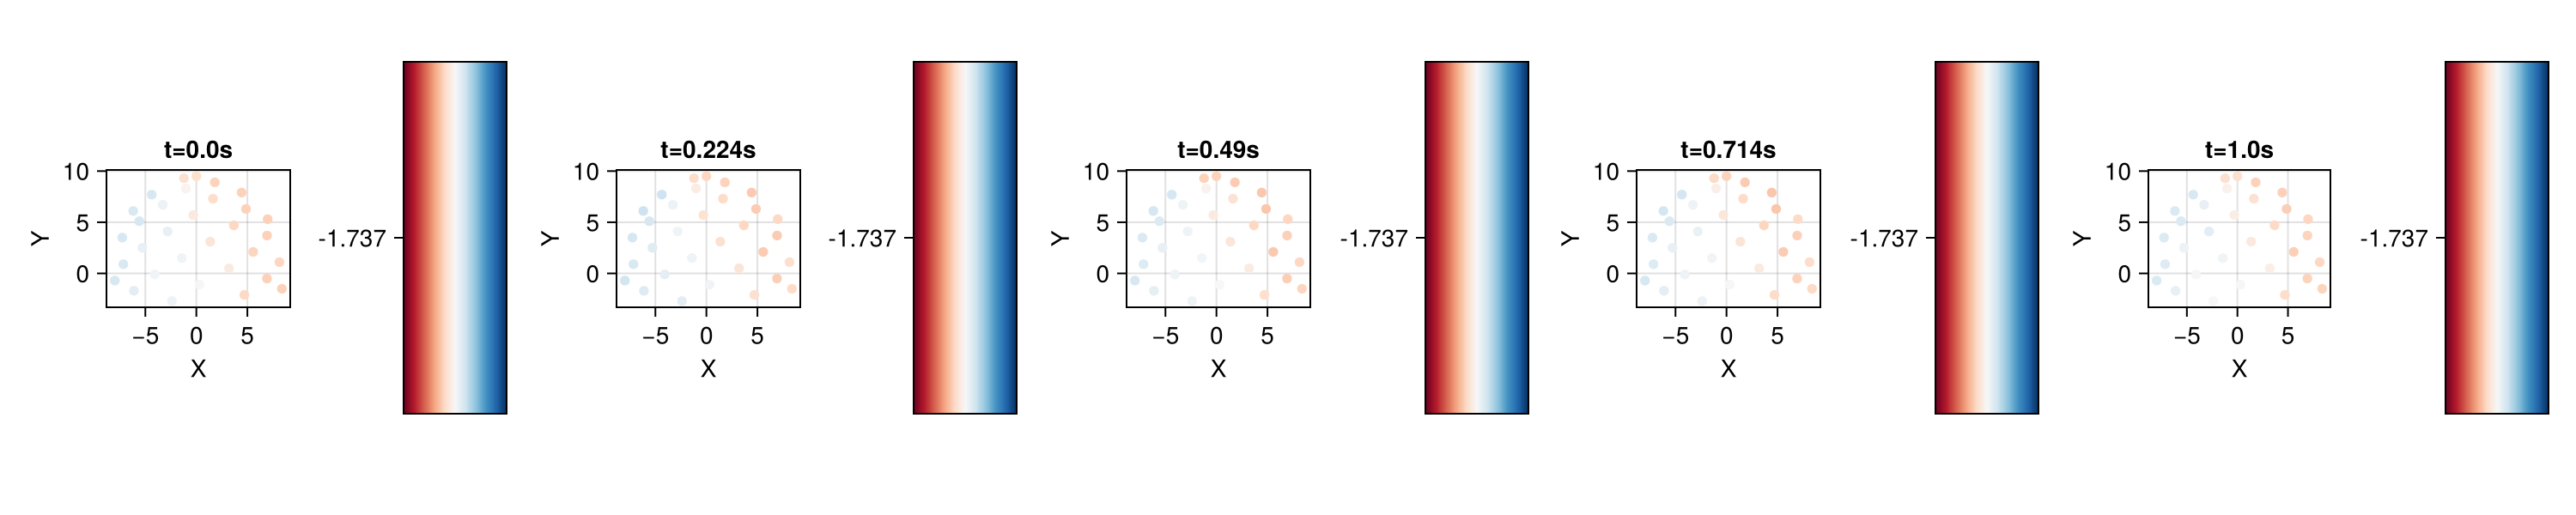

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ Пространственное распределение предсказаний отображено


In [27]:
using CairoMakie

# Пространственное распределение предсказанных данных (comparison)
num_time_steps = size(predicted_mat, 2)
time_vec = range(0, duration, length=num_time_steps)
time_indices = [1, max(1,div(num_time_steps,4)), max(1,div(num_time_steps,2)), max(1,3*div(num_time_steps,4)), num_time_steps]
time_indices = unique(clamp.(time_indices, 1, num_time_steps))

vmax_all = maximum(abs.(vcat(measured_mat[:], predicted_mat[:])))

n = length(time_indices)
fig_pred_spatial = Figure(resolution=(1500, 300))
for (i, t_idx) in enumerate(time_indices)
    t_idx = Int(clamp(t_idx, 1, num_time_steps))
    ax = Axis(fig_pred_spatial[1, 2*i - 1]; title="t=$(round(time_vec[t_idx], digits=3))s", xlabel="X", ylabel="Y", aspect=DataAspect())
    sc = scatter!(ax, sensor_positions[:, 1], sensor_positions[:, 2];
        color=predicted_mat[:, t_idx], colormap=:RdBu, markersize=8, colorrange=(-vmax_all, vmax_all))

    # Manual colorbar axis
    cbax = Axis(fig_pred_spatial[1, 2*i]; ylabel = "", width = 60)
    cvals = reshape(collect(range(-vmax_all, vmax_all, length=256)), 256, 1)
    heatmap!(cbax, cvals; colormap = :RdBu, colorrange = (-vmax_all, vmax_all))
    tick_idxs = [1, 64, 128, 192, 256]
    tick_vals = round.(collect(range(-vmax_all, vmax_all, length=length(tick_idxs))), digits=3)
    cbax.yticks = (tick_idxs, string.(tick_vals))
    cbax.xticks = ([], [])
end

display(fig_pred_spatial)
println("✓ Пространственное распределение предсказаний отображено")


In [28]:
# Метрики по временным шагам
time_metrics = analysis["time_step_metrics"]
time_steps = analysis["time_steps"]

println("📈 Метрики по времени:")
for (i, t) in enumerate(time_steps[1:min(5, length(time_steps))])
    m = time_metrics[t]
    println("   t=$(round(t, digits=3)): MSE=$(round(m["mse"], digits=6)), MAE=$(round(m["mae"], digits=6))")
end

📈 Метрики по времени:
   t=0.0: MSE=0.084106, MAE=0.263061
   t=0.02: MSE=0.097065, MAE=0.285258
   t=0.041: MSE=0.097161, MAE=0.286384
   t=0.061: MSE=0.084959, MAE=0.259039
   t=0.082: MSE=0.094837, MAE=0.279867


In [29]:
using CairoMakie

# ============================================================
# 1. Определяем все необходимые переменные
# ============================================================

grid_resolution = 40
x_range = domain_config["x_range"]
y_range = domain_config["y_range"]
z_range = domain_config["z_range"]

x_grid = LinRange(x_range[1], x_range[2], grid_resolution)
y_grid = LinRange(y_range[1], y_range[2], grid_resolution)

num_time_points_vis = 5
time_indices_vis = round.(Int, LinRange(1, num_time_steps, num_time_points_vis))

z_fixed = 0.0

norm_factor = haskey(analysis, "norm_factor") ? analysis["norm_factor"] : 1.0
vmax_all = maximum(abs.(vcat(measured_mat[:], predicted_mat[:])))

# ============================================================
# 2. Функция для предсказания на 2D сетке
# ============================================================

function predict_on_2d_grid(phi_fun, params, x_grid, y_grid, z_fixed, t_val, norm_factor=1.0)
    nx = length(x_grid)
    ny = length(y_grid)
    n_total = nx * ny
    
    coords = zeros(Float64, 4, n_total)
    
    idx = 0
    for j in 1:ny, i in 1:nx
        idx += 1
        coords[1, idx] = x_grid[i]
        coords[2, idx] = y_grid[j]
        coords[3, idx] = z_fixed
        coords[4, idx] = t_val
    end
    
    pred = phi_fun(coords, params)
    phi_pred = vec(pred[1, :]) .* norm_factor
    
    return reshape(phi_pred, nx, ny)'
end

# ============================================================
# 3. Визуализация 2D срезов (с исправлением)
# ============================================================

fig = Figure(resolution=(1400, 400 * num_time_points_vis))

# Сохраняем все heatmaps для colorbar
all_hms = []

for (i, t_idx) in enumerate(time_indices_vis)
    t_val = time_vec[t_idx]
    
    # Предсказание на 2D сетке
    phi_grid = predict_on_2d_grid(results.phi, results.params, x_grid, y_grid, z_fixed, t_val, norm_factor)
    
    # Визуализация heatmap
    ax = Axis(fig[i, 1]; 
              title="Предсказанное φ при t=$(round(t_val, digits=3))c", 
              xlabel="X", ylabel="Y", 
              aspect=DataAspect())
    
    hm = heatmap!(ax, x_grid, y_grid, phi_grid; 
                  colormap=:RdBu, 
                  colorrange=(-vmax_all, vmax_all))
    
    push!(all_hms, hm)
    
    # Контурные линии
    contour!(ax, x_grid, y_grid, phi_grid; 
             colormap=:RdBu, 
             colorrange=(-vmax_all, vmax_all),
             levels=10,
             linewidth=0.5)
    
    # Положение датчиков
    scatter!(ax, sensor_positions[:, 1], sensor_positions[:, 2]; 
             markersize=5, color=:green, marker=:circle)
    
    # Контур головы
    theta = LinRange(0, 2π, 100)
    lines!(ax, rx .* cos.(theta), rz .* sin.(theta); 
           color=:black, linewidth=2, linestyle=:dash)
end

# Colorbar (используем первый heatmap)
Colorbar(fig[1, 2], all_hms[1]; label="φ (V)", width=30)

display(fig)

println("✓ 2D визуализация распределения потенциала в домене создана")


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


ComputePipeline.ResolveException{ErrorException}: Failed to resolve _positions:
[ComputeEdge] _positions, input_text = #2898((position, text, arg1, ), changed, cached)
  @ /home/sasha/.julia/packages/Makie/Vn16E/src/basic_recipes/text.jl:54
[ComputeEdge] text = (::InputFunctionWrapper(:text, AttributeConvert{text, text}))((text_strings, ), changed, cached)
  @ /home/sasha/.julia/packages/Makie/Vn16E/src/conversions.jl:920
[ComputeEdge] text_strings = (::MapFunctionWrapper(#977))((computed_levels, labelformatter, ), changed, cached)
  @ unknown method location
[ComputeEdge] contour_points, contour_colors, computed_levels, lbl_pos1, lbl_pos2, lbl_pos3, computed_lbl_colors = (::MapFunctionWrapper(#974))((converted_1, converted_2, converted_3, zlevels, level_colors, labels, ), changed, cached)
  @ /home/sasha/.julia/packages/Makie/Vn16E/src/basic_recipes/contours.jl:281
[ComputeEdge] zlevels = (::MapFunctionWrapper(#973))((levels, zrange, ), changed, cached)
  @ unknown method location
[ComputeEdge] zrange = (::MapFunctionWrapper(nan_extrema))((converted_3, ), changed, cached)
  @ /home/sasha/.julia/packages/Makie/Vn16E/src/utilities/utilities.jl:84
  with edge inputs:
    converted_3 = Float32[0.31483138 0.31695443 … -0.40919176 -0.40920252; 0.31386673 0.31457815 … -0.40921333 -0.40926385; … ; 0.25436532 0.25685027 … -0.43896672 -0.441131; 0.25619894 0.26050025 … -0.4365811 -0.4394917]
Triggered by update of:
  dim_convert_2, dim_convert_3, arg1, dim_convert_1, arg3 or arg2
Due to ERROR: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore should be avoided.

If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
to enable scalar iteration globally or for the operations in question.

In [30]:
# Активируем GLMakie для интерактивной 3D графики
using GLMakie

# Параметры сетки
grid_resolution = 30  # Уменьшаем для скорости (30x30x30 = 27,000 точек)

# Диапазоны
x_range = domain_config["x_range"]
y_range = domain_config["y_range"]
z_range = domain_config["z_range"]

# Создаём 3D сетку
x_grid = LinRange(x_range[1], x_range[2], grid_resolution)
y_grid = LinRange(y_range[1], y_range[2], grid_resolution)
z_grid = LinRange(z_range[1], z_range[2], grid_resolution)

# Функция для предсказания на 3D сетке
function predict_3d_grid(phi_fun, params, x_grid, y_grid, z_grid, t_val, norm_factor=1.0)
    nx, ny, nz = length(x_grid), length(y_grid), length(z_grid)
    n_total = nx * ny * nz
    
    # Создаём батч координат [4, n_total]
    coords = zeros(Float64, 4, n_total)
    
    idx = 0
    for k in 1:nz, j in 1:ny, i in 1:nx
        idx += 1
        coords[1, idx] = x_grid[i]
        coords[2, idx] = y_grid[j]
        coords[3, idx] = z_grid[k]
        coords[4, idx] = t_val
    end
    
    # Предсказание
    pred = phi_fun(coords, params)
    return vec(pred[1, :]) .* norm_factor
end

# Выбираем временной срез
t_idx = div(num_time_steps, 2)
t_val = time_vec[t_idx]

# Вычисляем 3D поле потенциала
println("Вычисление 3D поля потенциала...")
phi_3d = predict_3d_grid(results.phi, results.params, x_grid, y_grid, z_grid, t_val, norm_factor)

# Reshape в 3D массив
phi_3d_array = reshape(phi_3d, length(x_grid), length(y_grid), length(z_grid))

# Интерактивная 3D визуализация
fig = Figure(resolution=(1000, 800))

# 3D scatter с цветом по потенциалу
ax3d = Axis3(fig[1, 1]; 
             title="3D распределение потенциала при t=$(round(t_val, digits=3))c",
             xlabel="X", ylabel="Y", zlabel="Z")

# Визуализация через voxel/heatmap3D!
# Для удобства вращения - используем scatter с downsampling
step = 3  # Шаг для уменьшения точек (каждая 3-я точка)
for k in 1:step:length(z_grid), j in 1:step:length(y_grid), i in 1:step:length(x_grid)
    x, y, z = x_grid[i], y_grid[j], z_grid[k]
    val = phi_3d_array[i, j, k]
    
    scatter!(ax3d, [x], [y], [z]; 
             markersize=20, 
             color=val, 
             colormap=:RdBu,
             colorrange=(-vmax_all, vmax_all))
end

# Добавляем датчики
scatter!(ax3d, sensor_positions[:, 1], sensor_positions[:, 2], sensor_positions[:, 3];
         markersize=20, color=:green, marker=:diamond)

# Colorbar
Colorbar(fig[1, 2], colormap=:RdBu, colorrange=(-vmax_all, vmax_all); label="φ (V)")

display(fig)

# Сохраняем как HTML для интерактивного просмотра в браузере
save("potential_3d_interactive.html", fig)
println("✓ Сохранено в potential_3d_interactive.html - откройте в браузере для полного интерактива")

Вычисление 3D поля потенциала...


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


ErrorException: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore should be avoided.

If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
to enable scalar iteration globally or for the operations in question.

### Распределение зарядов

In [31]:
using CUDA
using GLMakie
GLMakie.activate!()
# ============================================================
# 1. Параметры
# ============================================================

grid_res = 30
markersize = 8
x_min, x_max = domain_config["x_range"]
y_min, y_max = domain_config["y_range"]
z_min, z_max = domain_config["z_range"]

x_g = LinRange(x_min, x_max, grid_res)
y_g = LinRange(y_min, y_max, grid_res)
z_g = LinRange(z_min, z_max, grid_res)

dx = (x_max - x_min) / (grid_res - 1)
dy = (y_max - y_min) / (grid_res - 1)
dz = (z_max - z_min) / (grid_res - 1)

norm_factor = haskey(analysis, "norm_factor") ? analysis["norm_factor"] : 1.0
domain_limits = (x_min, x_max, y_min, y_max, z_min, z_max)

# ============================================================
# 2. GPU вычисление
# ============================================================

println("Создание координатной сетки...")

nx, ny, nz = grid_res, grid_res, grid_res
nt = num_time_steps
n_total = nx * ny * nz * nt

# Создаём координаты
coords_cpu = zeros(Float64, 4, n_total)

idx = 0
for t in 1:nt, k in 1:nz, j in 1:ny, i in 1:nx
    idx += 1
    coords_cpu[1, idx] = x_g[i]
    coords_cpu[2, idx] = y_g[j]
    coords_cpu[3, idx] = z_g[k]
    coords_cpu[4, idx] = time_vec[t]
end

println("Перенос на GPU (cu = CUDA array)...")
# Правильная функция: cu() создаёт CuArray
coords_gpu = cu(coords_cpu)  # <-- ИСПРАВЛЕНО

println("Предсказание на GPU...")
pred_gpu = results.phi(coords_gpu, results.params)

println("Перенос результатов на CPU...")
pred_cpu = Array(pred_gpu)

pred_cpu = vec(pred_cpu[1, :]) .* norm_factor

# Reshape: [time, x, y, z]
phi_4d = reshape(pred_cpu, nx, ny, nz, nt)

println("Вычисление заряда...")
charge_4d = zeros(size(phi_4d))

for t in 1:nt
    phi_3d = phi_4d[:, :, :, t]
    charge_3d = zeros(size(phi_3d))
    
    for k in 2:grid_res-1, j in 2:grid_res-1, i in 2:grid_res-1
        d2x = (phi_3d[i+1,j,k] - 2*phi_3d[i,j,k] + phi_3d[i-1,j,k]) / dx^2
        d2y = (phi_3d[i,j+1,k] - 2*phi_3d[i,j,k] + phi_3d[i,j-1,k]) / dy^2
        d2z = (phi_3d[i,j,k+1] - 2*phi_3d[i,j,k] + phi_3d[i,j,k-1]) / dz^2
        charge_3d[i,j,k] = -(d2x + d2y + d2z)
    end
    
    charge_4d[:, :, :, t] = charge_3d
end

phi_max = maximum(abs.(phi_4d))
charge_max = maximum(abs.(charge_4d))

phi_threshold = 0.10 * phi_max
charge_threshold = 0.05 * charge_max

println("Готово!")

# ============================================================
# 3. Визуализация
# ============================================================

function filter_points_3d(field_3d, threshold)
    nx, ny, nz = size(field_3d)
    pts_x, pts_y, pts_z, vals = Float64[], Float64[], Float64[], Float64[]
    
    for k in 1:nz, j in 1:ny, i in 1:nx
        val = field_3d[i,j,k]
        if abs(val) > threshold
            push!(pts_x, x_g[i])
            push!(pts_y, y_g[j])
            push!(pts_z, z_g[k])
            push!(vals, val)
        end
    end
    return pts_x, pts_y, pts_z, vals
end

fig = Figure(resolution=(1400, 800))

time_slider = Slider(fig[3, 1:2], 
                     range=1:num_time_steps, 
                     startvalue=div(num_time_steps, 2),
                     update_while_dragging=false)

time_label = Label(fig[2, 1:2], 
                   "t = $(round(time_vec[div(num_time_steps,2)], digits=3)) c",
                   fontsize=20)

initial_idx = div(num_time_steps, 2)
phi_3d_init = phi_4d[:, :, :, initial_idx]
charge_3d_init = charge_4d[:, :, :, initial_idx]

phi_pts = filter_points_3d(phi_3d_init, phi_threshold)
charge_pts = filter_points_3d(charge_3d_init, charge_threshold)

# Потенциал
ax1 = Axis3(fig[1, 1];
            title="Потенциал φ",
            xlabel="X", ylabel="Y", zlabel="Z",
            limits=domain_limits,
            azimuth=0.3, elevation=0.4)

scatter1 = scatter!(ax1, phi_pts[1], phi_pts[2], phi_pts[3];
         markersize=markersize,
         color=phi_pts[4],
         colormap=:RdBu,
         colorrange=(-phi_max, phi_max))

scatter!(ax1, sensor_positions[:,1], sensor_positions[:,2], sensor_positions[:,3];
         markersize=markersize, color=:green, marker=:diamond, strokewidth=2)

Colorbar(fig[1, 2], colormap=:RdBu, colorrange=(-phi_max, phi_max); label="φ (V)")

# Заряд
ax2 = Axis3(fig[1, 3];
            title="Заряд ρ",
            xlabel="X", ylabel="Y", zlabel="Z",
            limits=domain_limits,
            azimuth=0.3, elevation=0.4)

scatter2 = scatter!(ax2, charge_pts[1], charge_pts[2], charge_pts[3];
         markersize=markersize,
         color=charge_pts[4],
         colormap=:PuOr,
         colorrange=(-charge_max, charge_max))

scatter!(ax2, sensor_positions[:,1], sensor_positions[:,2], sensor_positions[:,3];
         markersize=markersize, color=:green, marker=:diamond, strokewidth=2)

Colorbar(fig[1, 4], colormap=:PuOr, colorrange=(-charge_max, charge_max); label="ρ")

# Обновление
function update_frame(t_idx)
    t_val = time_vec[t_idx]
    
    phi_3d = phi_4d[:, :, :, t_idx]
    charge_3d = charge_4d[:, :, :, t_idx]
    
    phi_pts = filter_points_3d(phi_3d, phi_threshold)
    charge_pts = filter_points_3d(charge_3d, charge_threshold)
    
    scatter1[1] = phi_pts[1]
    scatter1[2] = phi_pts[2]
    scatter1[3] = phi_pts[3]
    scatter1.color = phi_pts[4]
    
    scatter2[1] = charge_pts[1]
    scatter2[2] = charge_pts[2]
    scatter2[3] = charge_pts[3]
    scatter2.color = charge_pts[4]
    
    time_label.text[] = "t = $(round(t_val, digits=3)) c"
    ax1.title = "Потенциал φ (t=$(round(t_val, digits=3))c)"
    ax2.title = "Заряд ρ (t=$(round(t_val, digits=3))c)"
end

on(time_slider.value) do t_idx
    update_frame(t_idx)
end

display(fig)

println("✓ GPU визуализация готова!")


Создание координатной сетки...
Перенос на GPU (cu = CUDA array)...
Предсказание на GPU...
Перенос результатов на CPU...
Вычисление заряда...
Готово!


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


✓ GPU визуализация готова!


In [32]:
save("viz3d.html", fig)

## 10. Сравнение измеренных и предсказанных значений

In [33]:
using GLMakie

# ============================================================
# 1. Параметры
# ============================================================

grid_res = 25  # Небольшое разрешение для скорости

x_min, x_max = domain_config["x_range"]
y_min, y_max = domain_config["y_range"]
z_min, z_max = domain_config["z_range"]

x_g = LinRange(x_min, x_max, grid_res)
y_g = LinRange(y_min, y_max, grid_res)
z_g = LinRange(z_min, z_max, grid_res)

dx = (x_max - x_min) / (grid_res - 1)
dy = (y_max - y_min) / (grid_res - 1)
dz = (z_max - z_min) / (grid_res - 1)

norm_factor = haskey(analysis, "norm_factor") ? analysis["norm_factor"] : 1.0
domain_limits = (x_min, x_max, y_min, y_max, z_min, z_max)

# ============================================================
# 2. Предварительное вычисление всех временных срезов
# ============================================================

println("Предварительное вычисление всех временных срезов...")

# Функция вычисления
function compute_fields_single(phi_fun, params, x_g, y_g, z_g, t_val, norm_factor, grid_res)
    nx, ny, nz = length(x_g), length(y_g), length(z_g)
    n_total = nx * ny * nz
    
    coords = zeros(Float64, 4, n_total)
    
    idx = 0
    for k in 1:nz, j in 1:ny, i in 1:nx
        idx += 1
        coords[1, idx] = x_g[i]
        coords[2, idx] = y_g[j]
        coords[3, idx] = z_g[k]
        coords[4, idx] = t_val
    end
    
    pred = phi_fun(coords, params)
    phi_flat = vec(pred[1, :]) .* norm_factor
    phi_3d = reshape(phi_flat, grid_res, grid_res, grid_res)
    
    charge_3d = zeros(size(phi_3d))
    for k in 2:grid_res-1, j in 2:grid_res-1, i in 2:grid_res-1
        d2x = (phi_3d[i+1,j,k] - 2*phi_3d[i,j,k] + phi_3d[i-1,j,k]) / dx^2
        d2y = (phi_3d[i,j+1,k] - 2*phi_3d[i,j,k] + phi_3d[i,j-1,k]) / dy^2
        d2z = (phi_3d[i,j,k+1] - 2*phi_3d[i,j,k] + phi_3d[i,j,k-1]) / dz^2
        charge_3d[i,j,k] = -(d2x + d2y + d2z)
    end
    
    return phi_3d, charge_3d
end

# Функция фильтрации точек
function filter_points(field_3d, threshold)
    pts_x, pts_y, pts_z, vals = Float64[], Float64[], Float64[], Float64[]
    for k in 1:grid_res, j in 1:grid_res, i in 1:grid_res
        val = field_3d[i,j,k]
        if abs(val) > threshold
            push!(pts_x, x_g[i])
            push!(pts_y, y_g[j])
            push!(pts_z, z_g[k])
            push!(vals, val)
        end
    end
    return pts_x, pts_y, pts_z, vals
end

# Предварительно вычисляем все срезы
all_phi_data = []
all_charge_data = []

for t_idx in 1:num_time_steps
    t_val = time_vec[t_idx]
    phi_3d, charge_3d = compute_fields_single(
        results.phi, results.params, x_g, y_g, z_g, t_val, norm_factor, grid_res)
    
    push!(all_phi_data, (phi_3d, charge_3d))
    
    if t_idx % 5 == 0
        println("  Обработано $t_idx / $num_time_steps")
    end
end

# Вычисляем глобальные пороги и диапазоны
phi_max = maximum(abs.(first.(all_phi_data)))
charge_max = maximum(abs.(last.(all_phi_data)))

phi_threshold = 0.10 * phi_max
charge_threshold = 0.05 * charge_max

println("Готово! phi_max=$phi_max, charge_max=$charge_max")

# ============================================================
# 3. Создаём фигуру
# ============================================================

fig = Figure(resolution=(1400, 800))

# Слайдер с update_while_dragging=false для отзывчивости
time_slider = Slider(fig[3, 1:2], 
                     range=1:num_time_steps, 
                     startvalue=div(num_time_steps, 2),
                     update_while_dragging=false)  # <-- Не обновлять при перетаскивании

time_label = Label(fig[2, 1:2], 
                   "t = $(round(time_vec[div(num_time_steps,2)], digits=3)) c",
                   fontsize=20)

# ============================================================
# 4. Создаём графики
# ============================================================

initial_idx = div(num_time_steps, 2)
phi_3d_init, charge_3d_init = all_phi_data[initial_idx]

phi_pts_x, phi_pts_y, phi_pts_z, phi_vals = filter_points(phi_3d_init, phi_threshold)
charge_pts_x, charge_pts_y, charge_pts_z, charge_vals = filter_points(charge_3d_init, charge_threshold)

# Потенциал
ax1 = Axis3(fig[1, 1];
            title="Потенциал φ",
            xlabel="X", ylabel="Y", zlabel="Z",
            limits=domain_limits,
            azimuth=0.3, elevation=0.4)

scatter1 = scatter!(ax1, phi_pts_x, phi_pts_y, phi_pts_z;
         markersize=40,
         color=phi_vals,
         colormap=:RdBu,
         colorrange=(-phi_max, phi_max))

scatter!(ax1, sensor_positions[:,1], sensor_positions[:,2], sensor_positions[:,3];
         markersize=60, color=:green, marker=:diamond, strokewidth=2)

Colorbar(fig[1, 2], colormap=:RdBu, colorrange=(-phi_max, phi_max); label="φ (V)")

# Заряд
ax2 = Axis3(fig[1, 3];
            title="Заряд ρ",
            xlabel="X", ylabel="Y", zlabel="Z",
            limits=domain_limits,
            azimuth=0.3, elevation=0.4)

scatter2 = scatter!(ax2, charge_pts_x, charge_pts_y, charge_pts_z;
         markersize=40,
         color=charge_vals,
         colormap=:PuOr,
         colorrange=(-charge_max, charge_max))

scatter!(ax2, sensor_positions[:,1], sensor_positions[:,2], sensor_positions[:,3];
         markersize=60, color=:green, marker=:diamond, strokewidth=2)

Colorbar(fig[1, 4], colormap=:PuOr, colorrange=(-charge_max, charge_max); label="ρ")

# ============================================================
# 5. Функция быстрого обновления (использует предвычисленные данные)
# ============================================================

function update_frame(t_idx)
    t_val = time_vec[t_idx]
    
    # Берём предвычисленные данные
    phi_3d, charge_3d = all_phi_data[t_idx]
    
    # Фильтруем
    phi_pts_x, phi_pts_y, phi_pts_z, phi_vals = filter_points(phi_3d, phi_threshold)
    charge_pts_x, charge_pts_y, charge_pts_z, charge_vals = filter_points(charge_3d, charge_threshold)
    
    # Быстрое обновление точек
    scatter1[1] = phi_pts_x
    scatter1[2] = phi_pts_y
    scatter1[3] = phi_pts_z
    scatter1.color = phi_vals
    
    scatter2[1] = charge_pts_x
    scatter2[2] = charge_pts_y
    scatter2[3] = charge_pts_z
    scatter2.color = charge_vals
    
    # Обновляем текст
    time_label.text[] = "t = $(round(t_val, digits=3)) c"
    ax1.title = "Потенциал φ (t=$(round(t_val, digits=3))c)"
    ax2.title = "Заряд ρ (t=$(round(t_val, digits=3))c)"
end

# Подключаем слайдер
on(time_slider.value) do t_idx
    update_frame(t_idx)
end

display(fig)

println("✓ Готово! Двигайте слайдер для анимации.")


Предварительное вычисление всех временных срезов...


ErrorException: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore should be avoided.

If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
to enable scalar iteration globally or for the operations in question.

In [34]:
using Statistics, CairoMakie

# Гистограмма ошибок и RMSE/MAE по времени
errors = vec(measured_mat) .- vec(predicted_mat)

fig = Figure(resolution=(1200,800))
ax1 = Axis(fig[1,1]; title="Распределение ошибок на датчиках", xlabel="Ошибка (измеренное - предсказанное)", ylabel="Количество")
hist!(ax1, errors; bins=50, color=:gray, label="Errors")
vmean = mean(errors); vmed = median(errors)
vlines!(ax1, [vmean]; color=:red, linestyle=:dash, label="Mean")
vlines!(ax1, [vmed]; color=:green, linestyle=:dash, label="Median")
axislegend(ax1)

rmse_t = [sqrt(mean((measured_mat[:, i] .- predicted_mat[:, i]).^2)) for i in 1:size(measured_mat, 2)]
mae_t = [mean(abs.(measured_mat[:, i] .- predicted_mat[:, i])) for i in 1:size(measured_mat, 2)]
time_vec = range(0, duration, length=size(measured_mat, 2))
ax2 = Axis(fig[2,1]; title="RMSE and MAE over time", xlabel="Time (s)", ylabel="Error")
lines!(ax2, time_vec, rmse_t; label="RMSE")
lines!(ax2, time_vec, mae_t; label="MAE")
axislegend(ax2)

display(fig)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/sasha/.julia/packages/Makie/Vn16E/src/scenes.jl:264


GLMakie.Screen(...)